## IBM for Gizzard Shad (Fall 2019)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.stats import norm

In [2]:
def normPDF(z,mean,sd):
    return (1/np.sqrt(2*np.pi*sd))*np.exp(-(z-mean)**2/(2*sd**2))

In [3]:
mpar = {'surv_min': 0.0002,
        'surv_max': 0.70,
        'surv_alpha': 120.0,
        'surv_beta': -5.0,
        # growth
        'grow_max': 394.30,
        'grow_rate': 0.60,
        'grow_sd': 10.0,
        # survival
        'recruit_mean': 112.0,
        'recruit_sd': 40.0,
        'p_r': (0.002)*(0.002),
        'repr_int': -73.9542,
        'repr_z': 0.43019586,
        'egg_slope': 15000/7}


In [4]:
N = 50 # number of size classes
L_shad = 0.01   # lower size limit in cm
U_shad = 500.0    # upper size limit in cm - we want this to be larger than L-infty

####
# As we test the model, we will need some equal spaced meshpoints. 
# This can be moved down later.
zmesh =  L_shad + (np.arange(N) + 1/2) * (U_shad-L_shad)/N    # midpoint of N intervals
####


### Section 1 - Define the demographic functions and parameters
### Gizzard shad (gs) at LaGrange Ranch(LG) before carp invasion 1983-1999
### A dictionary of parameter values

### Growth function
#### given you are size z now returns the pdf of size z1 next time
#### computed from von Bertanaffy equation L(t) = L_inf(1-e^r(t-t0))
#### to find L(t+1) = L_inf*(1-e^(-r)) + e^(-r)*L(t)

In [5]:
def G_z1z(z1,z,mpar):
    mu = mpar['grow_max']*(1-np.exp(-mpar['grow_rate']))+ \
            np.exp(-mpar['grow_rate'])*z
    sig = mpar['grow_sd']
#    p_den_grow = norm.pdf(z1, loc = mu, scale = sig)
    p_den_grow = normPDF(z1, mean = mu, sd = sig)
    return p_den_grow


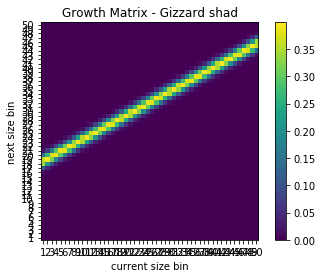

In [6]:
growth_matrix = np.zeros((N,N))
for x in range(len(growth_matrix)):
    growth_matrix[:,x] = G_z1z(zmesh, np.repeat(zmesh[x],N), mpar)/ \
    sum( G_z1z(zmesh, np.repeat(zmesh[x],N), mpar))
    
np.round(growth_matrix,2)    

plt.imshow(growth_matrix, origin = 'lower');
plt.colorbar()
plt.xlabel('current size bin') 
plt.ylabel('next size bin') 
plt.title('Growth Matrix - Gizzard shad') 
ax = plt.gca();
ax.set_xticks(np.arange(0, N, 1));
ax.set_yticks(np.arange(0, N, 1));
ax.set_xticklabels(np.arange(1, N+1, 1));
ax.set_yticklabels(np.arange(1, N+1, 1));
plt.show()


### Survival

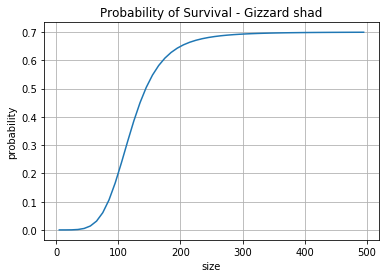

In [7]:
def s_z(z, mpar):
    return mpar['surv_min'] + (mpar['surv_max']-mpar['surv_min'])/(1+ \
         np.exp(mpar['surv_beta']*(np.log(z)-np.log(mpar['surv_alpha']))))
     
plt.plot(zmesh,s_z(zmesh,mpar))
plt.xlabel('size') 
plt.ylabel('probability') 
plt.title('Probability of Survival - Gizzard shad') 
plt.grid(True)
plt.show() 


### Probability of females spawning

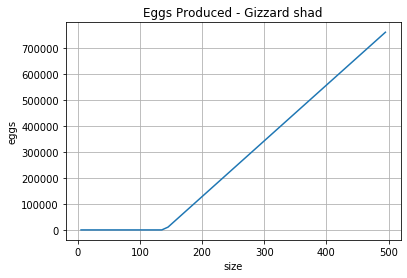

In [8]:
def p_bz(z, mpar):
    linear_p = mpar['repr_int'] + mpar['repr_z'] * z  # linear predictor
    return (1/(1+np.exp(-linear_p)))*0.9   # logistic transformation to probability with max 90%

# Using the batch fecundity vs length (figure 1a) from Jons & Miranda (1997)
# linear model
def b_z(z, mpar):
    Eggs = np.zeros(len(z))
    Eggs[z>140] = mpar['egg_slope']*(z[z>140]-140)
    return Eggs

plt.plot(zmesh,b_z(zmesh,mpar))
plt.xlabel('size') 
plt.ylabel('eggs') 
plt.title('Eggs Produced - Gizzard shad') 
plt.grid(True)
plt.show() 


### Recruits PDF

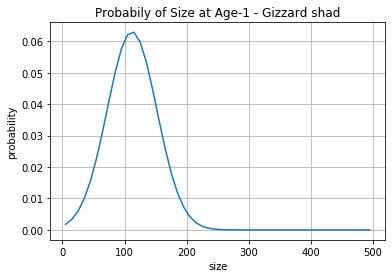

In [9]:
def c_0z1(z1, mpar):
    mu = mpar['recruit_mean']
    sig = mpar['recruit_sd']
#    p_den_recruit = norm.pdf(z1, loc = mu, scale = sig)
    p_den_recruit = normPDF(z1, mean = mu, sd = sig)
    return p_den_recruit

plt.plot(zmesh,c_0z1(zmesh,mpar))
plt.xlabel('size') 
plt.ylabel('probability') 
plt.title('Probabily of Size at Age-1 - Gizzard shad') 
plt.grid(True)
plt.show() 



 
## Section 2 - Functions to build IPM kernels P, F, and K


### Define the survival kernel

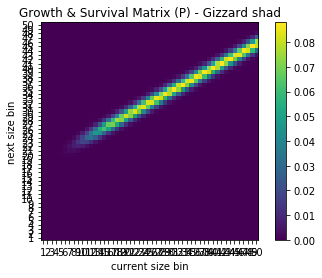

In [10]:
def P_z1z(z1, z, mpar):
    return s_z(z, mpar) * G_z1z(z1, z, mpar)

P_matrix = np.zeros((N,N))
for x in range(len(P_matrix)):
    P_matrix[:,x] = P_z1z(zmesh, np.repeat(zmesh[x],N), mpar)

np.round(P_matrix,2)    

plt.imshow(P_matrix, origin = 'lower');
plt.colorbar()
plt.xlabel('current size bin') 
plt.ylabel('next size bin') 
plt.title('Growth & Survival Matrix (P) - Gizzard shad') 
ax = plt.gca();
ax.set_xticks(np.arange(0, N, 1));
ax.set_yticks(np.arange(0, N, 1));
ax.set_xticklabels(np.arange(1, N+1, 1));
ax.set_yticklabels(np.arange(1, N+1, 1));
plt.show()



### Define the fecundity kernel

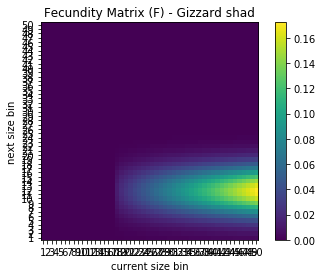

In [11]:
def F_z1z(z1, z, mpar):
    return p_bz(z, mpar) * b_z(z, mpar) * mpar['p_r'] *  \
    c_0z1(z1, mpar)

F_matrix = np.zeros((N,N))
for x in range(len(F_matrix)):
    F_matrix[:,x] = F_z1z(zmesh, np.repeat(zmesh[x],N), mpar)
    
np.round(F_matrix,2)    

plt.imshow(F_matrix, origin = 'lower');
plt.colorbar()
plt.xlabel('current size bin') 
plt.ylabel('next size bin') 
plt.title('Fecundity Matrix (F) - Gizzard shad') 
ax = plt.gca();
ax.set_xticks(np.arange(0, N, 1));
ax.set_yticks(np.arange(0, N, 1));
ax.set_xticklabels(np.arange(1, N+1, 1));
ax.set_yticklabels(np.arange(1, N+1, 1));
plt.show()


### The Gizzard Shad Matrix K

In [12]:
h = (U_shad - L_shad)/N
K = h*P_matrix + F_matrix
np.round(K,4)

np.real(np.linalg.eigvals(K))[0]


2.5810040643698553

#### Dynamical System
#### Initial size distribution

In [13]:
Tf = 10
n = np.zeros((len(zmesh),Tf))
#n[:,0]= norm.pdf(zmesh, loc = (U_shad + L_shad)/2, scale = 10)
n[:,0]= normPDF(zmesh, mean = (U_shad + L_shad)/2, sd = 10)


### Growth witihout Reproduction Graph

Text(0.5, 1.0, 'Probability of certain size as time progresses - Only Growth')

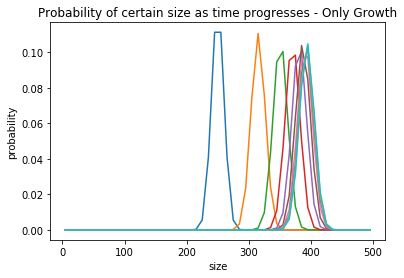

In [14]:
for x in range(1,Tf):
    n[:,x] = np.dot(growth_matrix,n[:,x-1])
    
# Now graph
f, ax = plt.subplots(1)
for t in range(0,Tf):
    ax.plot(zmesh,n[:,t])
plt.xlabel('size') 
plt.ylabel('probability') 
plt.title('Probability of certain size as time progresses - Only Growth') 


### Growth and Reproduction

Text(0.5, 1.0, 'Probability of certain size as time progresses')

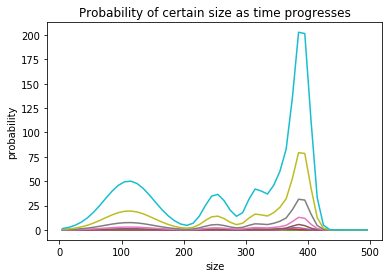

In [15]:
for x in range(1,Tf):
    n[:,x] = np.dot(K,n[:,x-1])

# Now graph
f, ax = plt.subplots(1)
for t in range(0,Tf):
    ax.plot(zmesh,n[:,t])
plt.xlabel('size') 
plt.ylabel('probability') 
plt.title('Probability of certain size as time progresses') 
